In [20]:
#In this code I'm going to see if we can train a NN from one game and have it predict positions from the next game
#Importing the libraries
from data_loader import FootballDataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU
import pickle
import os
import matplotlib.pyplot as plt
from ML_Functions_LoadArrays import *
import numpy as np
import shap


In [21]:
def get_xy_from_XG(XGPos1, XGPos2, team):
    if team == 'AAB':
        x = np.array(XGPos1, dtype=float) / 100 * 105 - 52.5  
        y = np.array(XGPos2, dtype=float) / 100 * 70 - 35
    elif team in ['AGF', 'BIF', 'FCK', 'FCN',  'SIF', 'SJE', 'VFF']:
        x = np.array(XGPos1, dtype=float) / 100 * 105 - 52.5  
        y = np.array(XGPos2, dtype=float) / 100 * 68 - 34
    elif team == 'FCM':
        x = np.array(XGPos1, dtype=float) / 100 * 104 - 52  
        y = np.array(XGPos2, dtype=float) / 100 * 65 - 32.5
    elif team in ['LYN', 'RFC']:
        x = np.array(XGPos1, dtype=float) / 100 * 102 - 51  
        y = np.array(XGPos2, dtype=float) / 100 * 65 - 32.5
    elif team == 'VB':
        x = np.array(XGPos1, dtype=float) / 100 * 108 - 54
        y = np.array(XGPos2, dtype=float) / 100 * 68 - 34
    return x, y

def get_shot_time(times_x, t, Us, Ball, XGNumbers, XGPos1, XGPos2, i, verbose=False):
    passed = False
    idxs = np.where(np.isclose(times_x, t, atol=0.03)) #I believe when XGDat says 50 seconds, it means the shot took place between 49-50 seconds, research shows this is usually true, but sometimes the time in XGData is 3 seconds off...
    if len(idxs[0]) == 0:
        if verbose:
            print(f"Warning: No close time found for {t} in times_x.")
        return 0, passed
    
    idxes = idxs[0][0]  # Get the first index where the time is close
    frames = np.arange(max(0 , idxes-40), min(len(Us), idxes+15)) #So we take the whole second, and also half a second before and after, so we take from 48.5-50.5
    for idx in frames:
        if Ball[idx][5] == 0:
             frames = np.delete(frames, np.where(frames == idx)) #take only the idx in which the ball is being played

    if len(frames) == 0: 
        if verbose:
            print(f"Ball not being played.")
        return 0, passed
    
    else:
        shooter = int(XGNumbers[i])
        shooter_x = float(XGPos1[i])
        shooter_y = float(XGPos2[i])
        #print(shooter, shooter_x, shooter_y, t/60)
        shooter_pos_in_data = next((j for j, player_data in enumerate(Us[frames[0]]) if int(player_data[4]) == shooter), None)

        if shooter_pos_in_data is None:
            if verbose:
                print(f"Warning: player {shooter} not found in Us[{frames[0]}]")
            return 0, passed

        distances = np.array([np.sqrt((Us[idx][shooter_pos_in_data][0] - Ball[idx][0])**2 + (Us[idx][shooter_pos_in_data][1] - Ball[idx][1])**2) for idx in frames])
        mask = ((np.abs(np.array([Us[idx][shooter_pos_in_data][0] for idx in frames]) - shooter_x) <= 1.5) &
                (np.abs(np.array([Us[idx][shooter_pos_in_data][1] for idx in frames]) - shooter_y) <= 1.5))
        distances = distances[mask]
        frames = frames[mask]

        if len(distances) == 0:
            if verbose:
                print(f"Warning: player {shooter} not found in Us[{frames[0]}] within 1.5m of where the player is supposed to be.")
            return 0, passed
        
        else : 
            if min(distances) > 2:
                if verbose:
                    print("Ball - Shooter distance > 2")
                return 0, passed
            passed = True
            if verbose:
                print(f"Shot time found at frame {frames[np.argmin(distances)]} with distance {min(distances)}")
           
            return frames[np.argmin(distances)], passed    

def get_sequence(Team, verbose=False):
    broken_NamesSC = ['Game_SJE_BIF_Score_2_2_Day_2024-11-24Z.pkl', 'Game_SJE_VFF_Score_2_2_Day_2024-09-01Z.pkl', 'Game_SJE_FCN_Score_1_4_Day_2024-10-06Z.pkl']
    NamesXG, NamesSC = SortGames('pippo', Team)
    columns = ['XG', 'Time', 'Half','ball_x', 'ball_y', 'ball_z', 'ball_speed']
    for i in range(1, 12):
        columns += [f'us_{i}_x', f'us_{i}_y', f'us_{i}_speed']
    for i in range(1, 12):
        columns += [f'them_{i}_x', f'them_{i}_y', f'them_{i}_speed']

    distances_list = []
    rows = []
    for igame in range(30):
        if NamesSC[igame] not in broken_NamesSC:
            Time, Ball, Us, Them = SecLoad(Team, NamesSC, igame)

            XGNumbers, XGTeam, XGValue, XGHalf, XGMin, XGSec, XGTimes, XGPos1, XGPos2 = (
                MacihneLearning_OptaLoad(Team, NamesXG, igame)
            )

            XG_x, XG_y = get_xy_from_XG(XGPos1, XGPos2, NamesSC[igame].split('_')[1])  # Assuming the pitch size is based on the team name in the file

            times_x = np.array([t[0] for t in Time])
            XGs = []
            for i, t in enumerate(XGTimes):
                if XGTeam[i] == Team and XGValue[i] > 0:
                    xg_moment = XGValue[i]
                    idxs = np.where(np.isclose(times_x, t, atol=0.03))[0][0] #I believe when XGDat says 50 seconds, it means the shot took place between 49-50 seconds
                    frames = np.arange(max(0 , idxs-40), min(len(Us), idxs+15)) #So we take the whole second, and also half a second before and after, so we take from 48.5-50.5
                    for idx in frames:
                        if Ball[idx][5] == 0:
                            frames = np.delete(frames, np.where(frames == idx))
                    if len(frames) != 0:

                        idx, passed = get_shot_time(times_x, t, Us, Ball, XGNumbers, XG_x, XG_y, i, verbose=verbose)

                        if passed:

                            distances = np.array([np.sqrt((Us[idx][j][0] - Ball[idx][0])**2 + (Us[idx][j][1] - Ball[idx][1])**2) for j in range(len(Us[idx]))])
                        
                            distances_list.append(min(distances))
                            index_ordered = np.argsort(distances)
                            Us[idx] = Us[idx][index_ordered]
                            distances = np.array([np.sqrt((Them[idx][j][0] - Ball[idx][0])**2 + (Them[idx][j][1] - Ball[idx][1])**2) for j in range(len(Them[idx]))])
                            index_ordered = np.argsort(distances)
                            Them[idx] = Them[idx][index_ordered]
                            # Player on the filed

                            frames_definig_play = np.arange(max(0 , idxs-125*2), idx) 
                            Ball_values = np.array([Ball[frame][5] for frame in frames_definig_play])
                            find_stop = np.where(Ball_values == 0)[0][-1] if np.any(Ball_values == 0) else None
                            if find_stop is not None:
                                frames_definig_play = frames_definig_play[find_stop:]

                            for time in frames_definig_play : 
                                row = {}
                                row['XG'] = xg_moment
                                row['Time'] = Time[time][0]
                                row['Half'] = XGHalf[i]
                                row['ball_x'] =  abs(Ball[time][0])
                                row['ball_y'] =  Ball[time][1]
                                row['ball_z'] =  Ball[time][2]
                                row['ball_speed'] =  Ball[time][3]
                                for j in range(len(Us[time])):
                                    row[f'us_{j+1}_x'] = Us[time][j][0]*np.sign(Ball[time][0])
                                    row[f'us_{j+1}_y'] = Us[time][j][1]
                                    row[f'us_{j+1}_speed'] = Us[time][j][3]
                                for j in range(len(Them[time])):    
                                    row[f'them_{j+1}_x'] = Them[time][j][0]*np.sign(Ball[time][0])
                                    row[f'them_{j+1}_y'] = Them[time][j][1]
                                    row[f'them_{j+1}_speed'] = Them[time][j][3]
                                # Filling the rest of the row with NaN
                                if len(Us[time]) < 11:
                                    for j in range(len(Us[time]), 11):
                                        row[f'us_{j+1}_x'] = np.nan
                                        row[f'us_{j+1}_y'] = np.nan
                                        row[f'us_{j+1}_speed'] = np.nan
                                if len(Them[time]) < 11:
                                    for j in range(len(Them[time]), 11):
                                        row[f'them_{j+1}_x'] = np.nan
                                        row[f'them_{j+1}_y'] = np.nan
                                        row[f'them_{j+1}_speed'] = np.nan
                                rows.append(row)
                            XGs.append(XGValue[i])
                            

    total_XG_data = pd.DataFrame(rows, columns=columns)
    return total_XG_data, XGs

dist_l = []
#tXG_all, Xgs = get_sequence('LYN', verbose=False) #1 team takes +- 1 min,  
#print("Team AAB done")
#
#for team in ['AGF', 'BIF', 'FCK', 'FCM', 'FCN', 'RFC', 'SIF', 'SJE', 'VB', 'VFF', 'AAB']: # missing 
#    tXG, d_l = get_sequence(team) 
#    print(f"Team {team} done")
#    dist_l += d_l
#    tXG_all = pd.concat([tXG_all, tXG], ignore_index=True)
#print(tXG_all.shape)

In [22]:
#tXG_all = tXG.to_csv('XGData_forNN.csv', index=False)

In [23]:
tXG_all = pd.read_csv('XGData_forNN.csv')
cols_to_drop = [col for col in tXG_all.columns if 'speed' in col and col != 'ball_speed']
#cols_to_drop += [col for col in tXG_all.columns if '11'  in col]
tXG_all = tXG_all.drop(columns=cols_to_drop)


shot = 0 
XG_n = [0]
i = 0
while i < len(tXG_all):
    XG_n.append(shot)
    while i + 1 < len(tXG_all) and abs(tXG_all['XG'][i] - tXG_all['XG'][i + 1]) < 0.0001:
        i += 1
        XG_n.append(shot)
    shot += 1
    i += 1

# Rimuovi il primo elemento extra se necessario (perché XG_n parte da [0])
XG_n = XG_n[:len(tXG_all)]
tXG_all['XG_n'] = XG_n

In [24]:
train_positions = tXG_all.drop(tXG_all.columns[[0, 2]], axis=1)

grpous = tXG_all.groupby('XG_n')
xg_groups = {group['XG'].iloc[0]: {'group': group, 'n': name} for name, group in grpous}
print('first gropup:', xg_groups[list(xg_groups.keys())[0]])
train_X = []
train_y = []
appo = []

for xg_val, group_info in xg_groups.items():
    group_df = group_info['group']
    appo = []
    for i in range(group_df.shape[0] - 1, -1, -5):
        appo.append(group_df.drop(['XG', 'Half' , 'XG_n'], axis=1).iloc[i].values)
    appo = np.array(appo)
    appo = np.flip(appo, axis=0)  # Flip the sequence per avere ordine temporale corretto
    train_X.append(appo)
    train_y.append(xg_val)

train_X = np.array(train_X, dtype=object)
train_y = np.array(train_y, dtype=float)

print("Shape of train_X:", train_X.shape)
print("Shape of train_y:", train_y.shape)

first gropup: {'group':            XG     Time  Half  ball_x  ball_y  ball_z  ball_speed  us_1_x  \
0    0.917393  1955.96     1    1.39   10.13    0.23        1.89   35.61   
1    0.917393  1956.00     1    1.30   10.12    0.23        1.92   35.60   
2    0.917393  1956.04     1    1.22   10.10    0.23        1.93   35.60   
3    0.917393  1956.08     1    1.12   10.09    0.23        1.94   35.59   
4    0.917393  1956.12     1    1.03   10.07    0.23        1.95   35.57   
..        ...      ...   ...     ...     ...     ...         ...     ...   
252  0.917393  1966.04     1   50.86   -0.82    0.17        5.98  -22.64   
253  0.917393  1966.08     1   50.96   -1.02    0.17        5.89  -22.61   
254  0.917393  1966.12     1   51.07   -1.20    0.16        5.87  -22.59   
255  0.917393  1966.16     1   51.14   -1.40    0.17        5.91  -22.57   
256  0.068112  3299.40     2   51.45   33.11    0.29       13.62  -17.32   

     us_1_y  us_2_x  ...  them_7_y  them_8_x  them_8_y  them_9_

In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

maxlen = max([seq.shape[0] for seq in train_X])

train_X_padded = pad_sequences(train_X, maxlen=maxlen, dtype='float32', padding='post')
train_y = np.nan_to_num(train_y, nan=0.0, posinf=0.0, neginf=0.0)

num_samples, timesteps, num_features = train_X_padded.shape
scaler = StandardScaler()
train_X_padded = scaler.fit_transform(train_X_padded.reshape(-1, num_features)).reshape(num_samples, timesteps, num_features)
train_X_padded = np.nan_to_num(train_X_padded, nan=-100.0, posinf=0.0, neginf=0.0)

print("Shape of train_X_padded:", train_X_padded.shape)
print("Shape of train_y:", train_y.shape)

Shape of train_X_padded: (145, 53, 49)
Shape of train_y: (145,)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    train_X_padded, train_y, test_size=0.2, random_state=42
)
print("NaN in train_X_padded:", np.isnan(train_X_padded).any())
print("NaN in train_y:", np.isnan(train_y).any())
print("Inf in train_X_padded:", np.isinf(train_X_padded).any())
print("Inf in train_y:", np.isinf(train_y).any())

model = Sequential()
model.add(SimpleRNN(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(32, return_sequences=False)) 
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.fit(X_train, train_y, epochs=15, batch_size=64, validation_split=0.2 , verbose=1 , shuffle=True)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")
# Plot predictions vs actual values
predictions = model.predict(X_test)

NaN in train_X_padded: False
NaN in train_y: False
Inf in train_X_padded: False
Inf in train_y: False
Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - loss: 0.1711 - mae: 0.4020 - val_loss: 0.1384 - val_mae: 0.3539
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1505 - mae: 0.3768 - val_loss: 0.1163 - val_mae: 0.3225
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1295 - mae: 0.3463 - val_loss: 0.0934 - val_mae: 0.2869
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1185 - mae: 0.3279 - val_loss: 0.0716 - val_mae: 0.2492
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0945 - mae: 0.2886 - val_loss: 0.0518 - val_mae: 0.2078
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0754 - mae: 0.2451 - val_loss: 0.0347 - val_mae: 0.1624
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0697 - mae: 0.2272 - val_loss: 0.0226 - val_mae: 0.1208
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0503 - mae: 0.1687 - val_loss: 0.

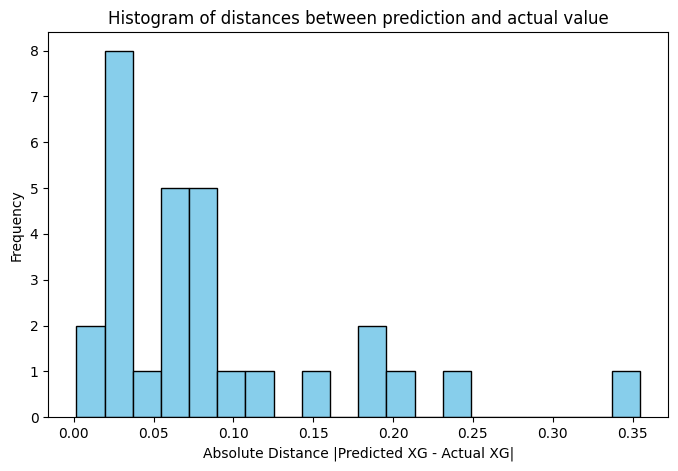

In [27]:
distances = np.abs(predictions.flatten() - y_test)

plt.figure(figsize=(8, 5))
plt.hist(distances, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Absolute Distance |Predicted XG - Actual XG|')
plt.ylabel('Frequency')
plt.title('Histogram of distances between prediction and actual value')
plt.show()

Text(0, 0.5, 'Loss')

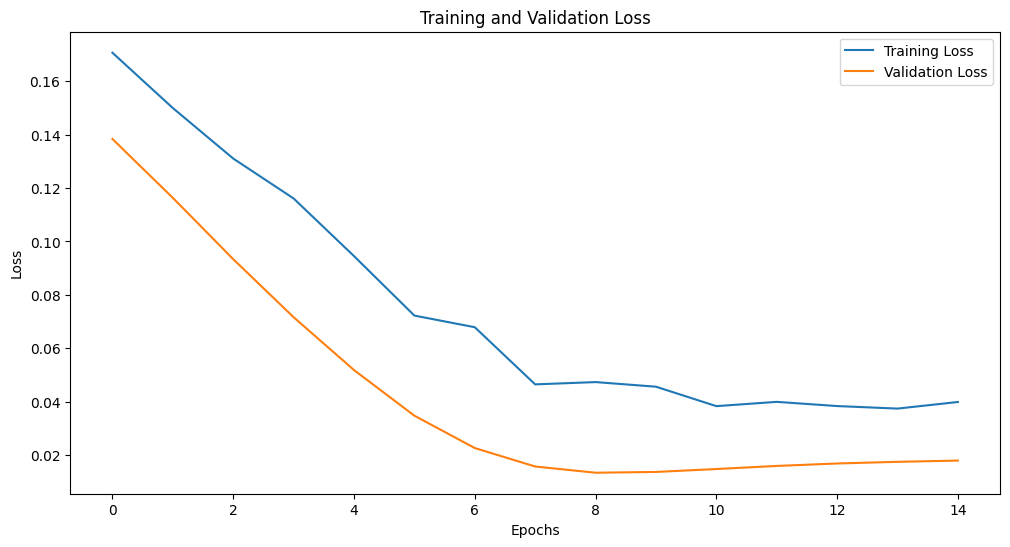

In [28]:
#Plot training history
history = model.history.history
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss') 
plt.legend()  
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [29]:
X_sample = X_test[:20]
X_sample_mean = np.mean(X_sample, axis=1) 

def model_predict_2d(x):
    x_seq = np.repeat(x[:, np.newaxis, :], X_test.shape[1], axis=1)
    return model.predict(x_seq)

explainer = shap.KernelExplainer(model_predict_2d, X_sample_mean)
shap_values = explainer.shap_values(X_sample_mean, nsamples=50, silent=True, progress_bar=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

/home/francesco/.local/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.653e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

/home/francesco/.local/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.110e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

/home/francesco/.local/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=7.563e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


       feature  mean_abs_shap
26     us_11_y       0.017790
38    them_6_y       0.013121
3       ball_z       0.008460
15      us_6_x       0.008119
21      us_9_x       0.007585
8       us_2_y       0.007513
17      us_7_x       0.007307
24     us_10_y       0.006973
11      us_4_x       0.006823
19      us_8_x       0.006750
20      us_8_y       0.006548
42    them_8_y       0.005485
22      us_9_y       0.005352
1       ball_x       0.005031
36    them_5_y       0.004956
18      us_7_y       0.004786
33    them_4_x       0.004736
39    them_7_x       0.004717
40    them_7_y       0.004205
31    them_3_x       0.004072
44    them_9_y       0.003908
41    them_8_x       0.003819
7       us_2_x       0.003431
10      us_3_y       0.003385
23     us_10_x       0.003326
43    them_9_x       0.003097
5       us_1_x       0.003051
30    them_2_y       0.003049
2       ball_y       0.002685
0         Time       0.002598
35    them_5_x       0.002541
48   them_11_y       0.002474
4   ball_s

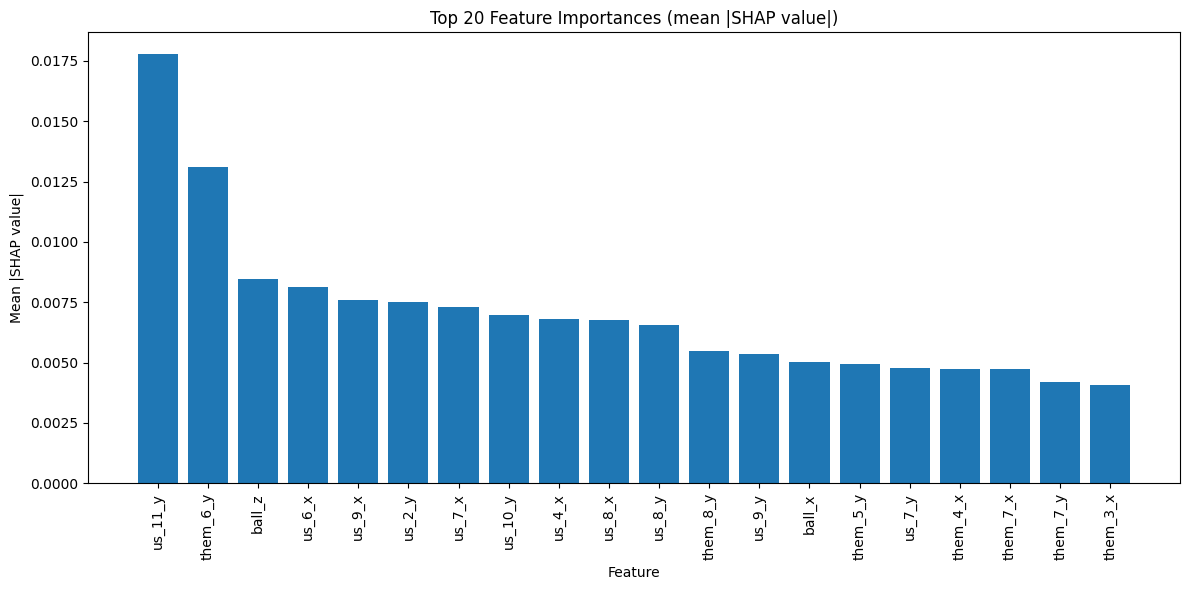

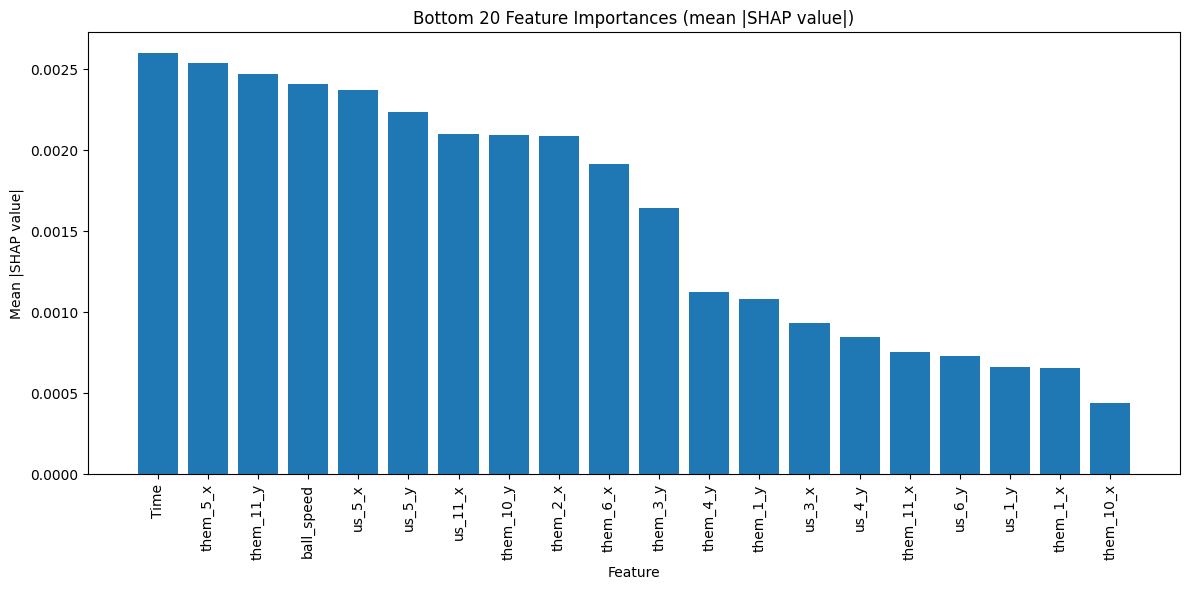

Numero totale di variabili: 49


In [30]:
mean_importance = np.mean(np.abs(shap_values), axis=0).ravel() 

feature_names = train_positions.drop(['XG_n'], axis=1).columns.tolist()

importances_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_importance
}).sort_values('mean_abs_shap', ascending=False)

print(importances_df)

plt.figure(figsize=(12, 6))
plt.bar(importances_df['feature'][:20], importances_df['mean_abs_shap'][:20])
plt.xticks(rotation=90)
plt.title('Top 20 Feature Importances (mean |SHAP value|)')
plt.ylabel('Mean |SHAP value|')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()
# Plot the 20 least important features
plt.figure(figsize=(12, 6))
plt.bar(importances_df['feature'][-20:], importances_df['mean_abs_shap'][-20:])
plt.xticks(rotation=90)
plt.title('Bottom 20 Feature Importances (mean |SHAP value|)')
plt.ylabel('Mean |SHAP value|')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

print(f"Numero totale di variabili: {len(importances_df)}")

In [31]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU

# Trova le 10 feature meno importanti
worst_10_features = importances_df.tail(20)['feature'].tolist()

# Rimuovi queste colonne da train_positions
train_positions_reduced = train_positions.drop(columns=worst_10_features)

# Ricostruisci train_X con le nuove colonne
new_feature_indices = [train_positions.columns.get_loc(col) for col in train_positions_reduced.columns if col != 'XG_n']

# Ricostruisci train_X con le nuove feature
train_X_reduced = []
for seq in train_X:
    # Se la sequenza è vuota, salta
    if seq.shape[0] == 0:
        continue
    train_X_reduced.append(seq[:, new_feature_indices])
train_X_reduced = np.array(train_X_reduced, dtype=object)

# Padding e scaling
maxlen = max([seq.shape[0] for seq in train_X_reduced])
num_features_reduced = train_X_reduced[0].shape[1]


train_X_padded_reduced = pad_sequences(train_X_reduced, maxlen=maxlen, dtype='float32', padding='post')
scaler_reduced = StandardScaler()
num_samples = train_X_padded_reduced.shape[0]
train_X_padded_reduced = scaler_reduced.fit_transform(train_X_padded_reduced.reshape(-1, num_features_reduced)).reshape(num_samples, maxlen, num_features_reduced)
train_X_padded_reduced = np.nan_to_num(train_X_padded_reduced, nan=-100.0, posinf=0.0, neginf=0.0)

# Split train/test
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    train_X_padded_reduced, train_y, test_size=0.2, random_state=42
)

model_r = Sequential()
model_r.add(SimpleRNN(64, return_sequences=True, input_shape=(maxlen, num_features_reduced)))
model_r.add(Dropout(0.3))
model_r.add(GRU(64, return_sequences=True))
model_r.add(Dropout(0.3))
model_r.add(LSTM(64, return_sequences=True))
model_r.add(Dropout(0.3))
model_r.add(GRU(32, return_sequences=False))
model_r.add(Dropout(0.3))
model_r.add(Dense(32, activation='relu'))
model_r.add(Dropout(0.3))
model_r.add(Dense(32, activation='relu'))
model_r.add(Dense(1, activation='sigmoid'))

model_r.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model_r.fit(X_train_r, y_train_r, epochs=15, batch_size=64, validation_split=0.2, verbose=1, shuffle=True)

# Valutazione
loss_r, mae_r = model_r.evaluate(X_test_r, y_test_r)
print(f"Test Loss (reduced): {loss_r}, Test MAE (reduced): {mae_r}")

Epoch 1/15


/home/francesco/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step - loss: 0.1603 - mae: 0.3856 - val_loss: 0.1295 - val_mae: 0.3393
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1334 - mae: 0.3473 - val_loss: 0.1055 - val_mae: 0.2993
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1083 - mae: 0.3085 - val_loss: 0.0835 - val_mae: 0.2602
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0864 - mae: 0.2718 - val_loss: 0.0638 - val_mae: 0.2159
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0730 - mae: 0.2404 - val_loss: 0.0472 - val_mae: 0.1732
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0579 - mae: 0.2002 - val_loss: 0.0348 - val_mae: 0.1442
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0415 - mae: 0.1638 - val_loss: 0.0259 - val_mae: 0.1250
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0363 - mae: 0.1433 - val_loss: 0.0211 - val_mae: 0.1113
Epoch 9/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0394 - mae: 0.1395 - val_loss: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


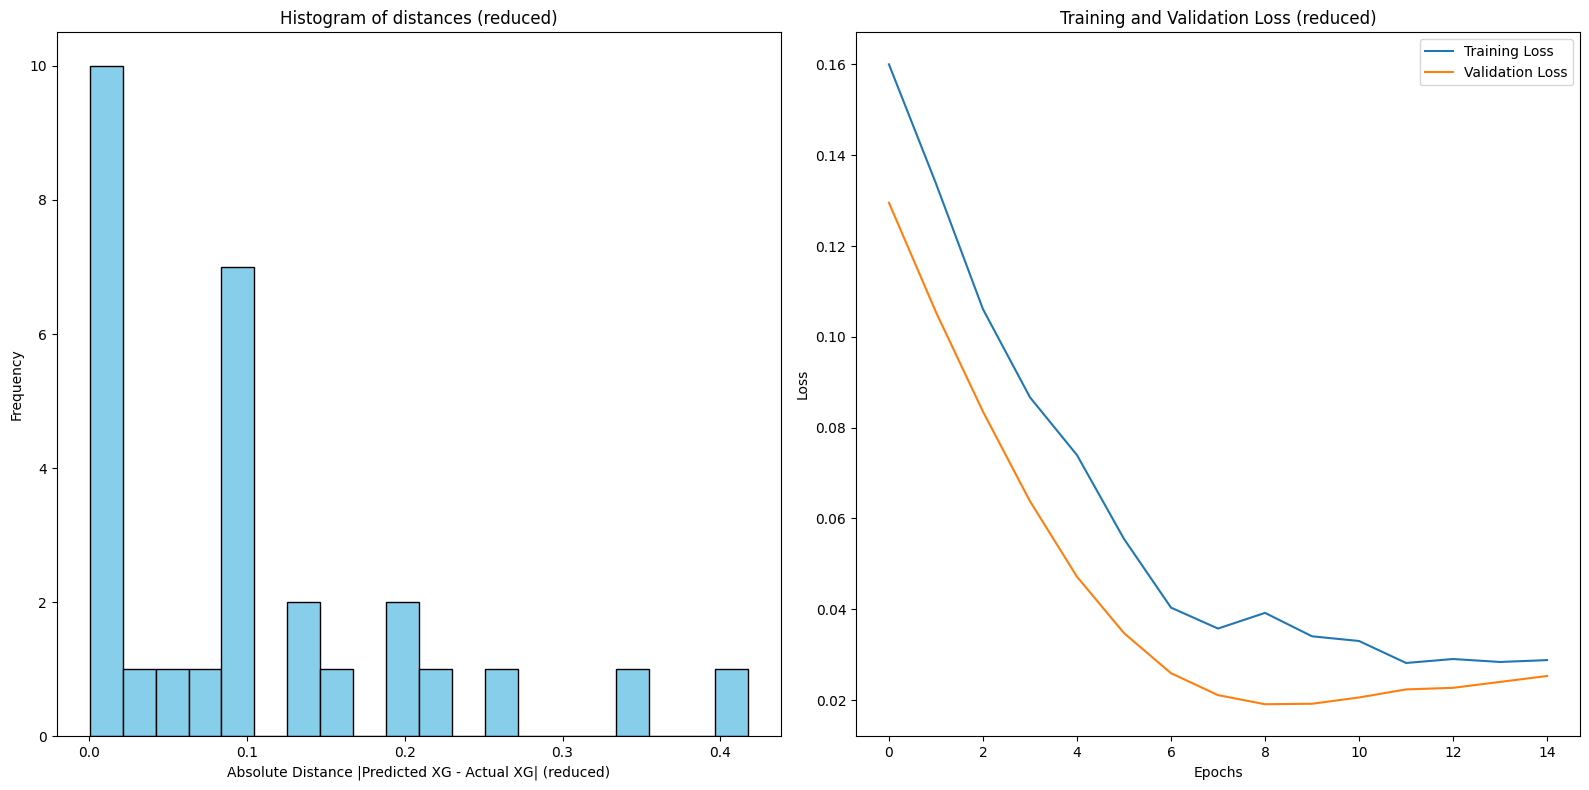

In [32]:
distances_r = np.abs(model_r.predict(X_test_r).flatten() - y_test_r)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Istogramma delle distanze
axs[0].hist(distances_r, bins=20, color='skyblue', edgecolor='black')
axs[0].set_xlabel('Absolute Distance |Predicted XG - Actual XG| (reduced)')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of distances (reduced)')

# History del modello ridotto
history_r = model_r.history.history
axs[1].plot(history_r['loss'], label='Training Loss')
axs[1].plot(history_r['val_loss'], label='Validation Loss')
axs[1].set_title('Training and Validation Loss (reduced)')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

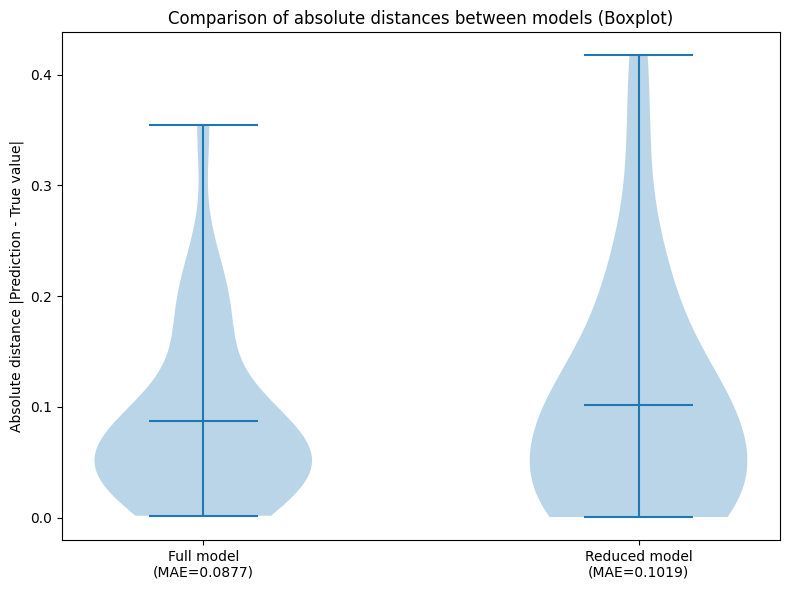

In [33]:
mae_full = np.mean(distances)
mae_reduced = np.mean(distances_r)

plt.figure(figsize=(8, 6))
plt.violinplot([distances, distances_r], showmeans=True)
plt.xticks([1, 2], [f'Full model\n(MAE={mae_full:.4f})', f'Reduced model\n(MAE={mae_reduced:.4f})'])
plt.ylabel('Absolute distance |Prediction - True value|')
plt.title('Comparison of absolute distances between models (Boxplot)')
plt.tight_layout()
plt.show()


In [34]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU

# Rimuovi tutte le colonne relative alla palla da train_positions
ball_features = [col for col in train_positions.columns if col.startswith('ball_') or col == 'ball_x' or col == 'ball_y' or col == 'ball_z' or col == 'ball_speed']
train_positions_noball = train_positions.drop(columns=ball_features)

# Ricostruisci train_X senza le feature della palla
feature_indices_noball = [train_positions.columns.get_loc(col) for col in train_positions_noball.columns if col != 'XG_n']

train_X_noball = []
for seq in train_X:
    if seq.shape[0] == 0:
        continue
    train_X_noball.append(seq[:, feature_indices_noball])
train_X_noball = np.array(train_X_noball, dtype=object)

# Padding e scaling

maxlen_noball = max([seq.shape[0] for seq in train_X_noball])
num_features_noball = train_X_noball[0].shape[1]

train_X_padded_noball = pad_sequences(train_X_noball, maxlen=maxlen_noball, dtype='float32', padding='post')
scaler_noball = StandardScaler()
num_samples_noball = train_X_padded_noball.shape[0]
train_X_padded_noball = scaler_noball.fit_transform(train_X_padded_noball.reshape(-1, num_features_noball)).reshape(num_samples_noball, maxlen_noball, num_features_noball)
train_X_padded_noball = np.nan_to_num(train_X_padded_noball, nan=-100.0, posinf=0.0, neginf=0.0)

# Split train/test

X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(
    train_X_padded_noball, train_y, test_size=0.2, random_state=42
)

model_nb = Sequential()
model_nb.add(SimpleRNN(64, return_sequences=True, input_shape=(maxlen_noball, num_features_noball)))
model_nb.add(Dropout(0.3))
model_nb.add(GRU(64, return_sequences=True))
model_nb.add(Dropout(0.3))
model_nb.add(LSTM(64, return_sequences=True))
model_nb.add(Dropout(0.3))
model_nb.add(GRU(32, return_sequences=False))
model_nb.add(Dropout(0.3))
model_nb.add(Dense(32, activation='relu'))
model_nb.add(Dropout(0.3))
model_nb.add(Dense(32, activation='relu'))
model_nb.add(Dense(1, activation='sigmoid'))

model_nb.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model_nb.fit(X_train_nb, y_train_nb, epochs=15, batch_size=64, validation_split=0.2, verbose=1, shuffle=True)

# Valutazione
loss_nb, mae_nb = model_nb.evaluate(X_test_nb, y_test_nb)
print(f"Test Loss (no ball): {loss_nb}, Test MAE (no ball): {mae_nb}")
distances_nb = np.abs(model_nb.predict(X_test_nb).flatten() - y_test_nb)

Epoch 1/15


/home/francesco/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step - loss: 0.1736 - mae: 0.4037 - val_loss: 0.1447 - val_mae: 0.3617
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1525 - mae: 0.3755 - val_loss: 0.1288 - val_mae: 0.3386
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1405 - mae: 0.3617 - val_loss: 0.1128 - val_mae: 0.3124
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1227 - mae: 0.3336 - val_loss: 0.0965 - val_mae: 0.2853
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1092 - mae: 0.3106 - val_loss: 0.0807 - val_mae: 0.2571
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0910 - mae: 0.2757 - val_loss: 0.0656 - val_mae: 0.2263
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0753 - mae: 0.2454 - val_loss: 0.0511 - val_mae: 0.1923
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0732 - mae: 0.2393 - val_loss: 0.0378 - val_mae: 0.1582
Epoch 9/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0567 - mae: 0.2004 - val_loss: 

/tmp/ipykernel_119991/242753351.py:4: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.15`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(


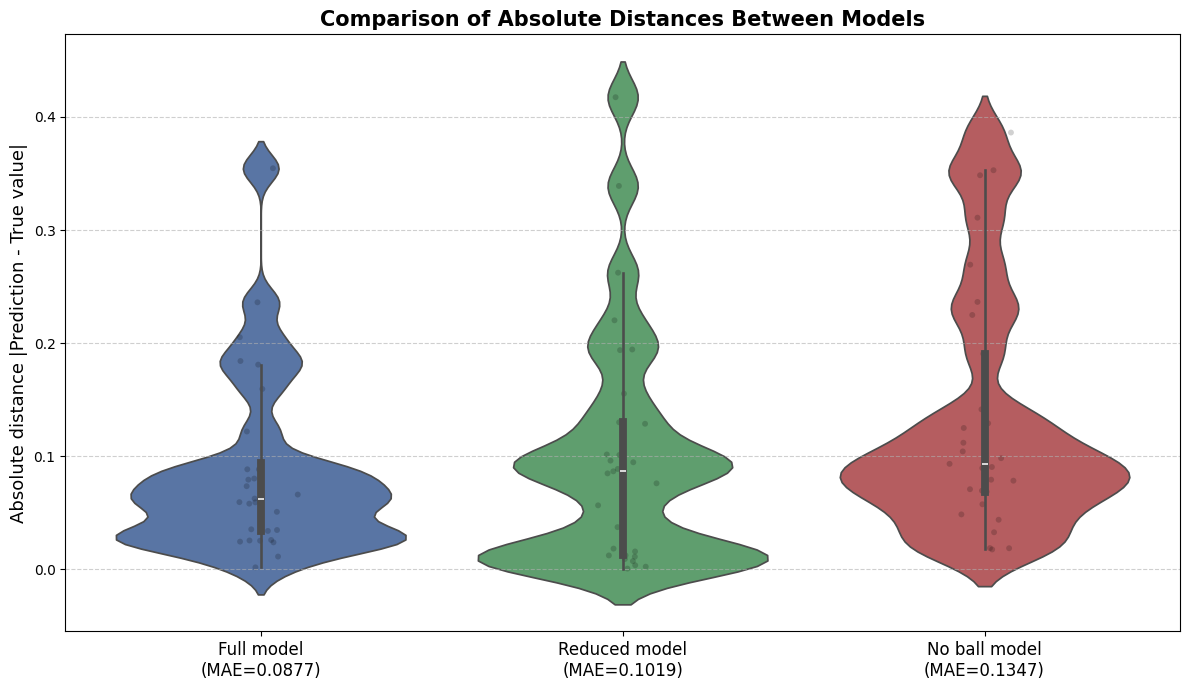

In [35]:
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.violinplot(
    data=[distances, distances_r, distances_nb],
    inner="box",
    palette=["#4C72B0", "#55A868", "#C44E52"],
    bw=0.15
)

# Overlay scatter plot of individual points (jittered for visibility, no negative X)
for i, dist in enumerate([distances, distances_r, distances_nb]):
    # Jitter limitato per non andare mai sotto 0 sull'asse X
    x_jitter = np.clip(np.random.normal(i, 0.04, size=len(dist)), i - 0.15, i + 0.15)
    plt.scatter(
        x_jitter,
        np.clip(dist, 0, None), 
        alpha=0.18,
        color='black',
        s=18,
        edgecolor='none'
    )

plt.xticks([0, 1, 2], [
    f'Full model\n(MAE={mae_full:.4f})',
    f'Reduced model\n(MAE={mae_reduced:.4f})',
    f'No ball model\n(MAE={mae_nb:.4f})'
], fontsize=12)
plt.ylabel('Absolute distance |Prediction - True value|', fontsize=13)
plt.title('Comparison of Absolute Distances Between Models', fontsize=15, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()